# OPTRAM : Little Washita

This notebook is divided in the following sections: 


1. [Python packages](#section_1)
2. [Functions](#section_2) 
3. [Region of study](#section_3) (WIP)  
4. [Data](#section_4) (WIP)
 - [4.1 Sensor](#section_4_1) (WIP)
 - [4.2 Satellite](#section_4_1) (WIP)
5. [Data fusion](#section_5) (WIP)
6. [Model parametrization](#section_6) (WIP)
7. [W maps](#section_7) (WIP)

<a id='section_1'></a>
## 1 - Python packages

In [3]:
# MODULE                                             # DESCRIPTION
import numpy as np                                   # scientific computing
import numpy.ma as ma                                # numpy masked arrays
import pandas as pd                                  # data analysis and manipulation
import geopandas as gpd                              # geospatial data analysis
import utm                                           # bidirectional UTM-WGS84 converter
import folium                                        # interactive data visualization
import re                                            # regular expressions
from osgeo import gdal, gdalconst                    # raster and geospatial data proc.
import rasterio as rs                                # raster and geospatial data proc.
import matplotlib.pyplot as plt                      # create visualizations
import seaborn as sns                                # create visualizations
import datetime                                      # datetime manipulation
import glob                                          # unix pathname expansion
import haversine as hs                               # distances between points
import dask                                          # parallel computing
from dask.distributed import Client                  # set custom parameters in cluster
import dask.dataframe as dd                          # manipulation of lazy dask dfs
import datashader as ds                              # visualization for big data
import colorcet as cc                                # colormaps for datashader 
from sklearn import linear_model                     # regression 
from sklearn.metrics import mean_absolute_error      # to compute MAE
from sklearn.metrics import mean_squared_error       # to compute RMSE
from sklearn.metrics import r2_score                 # to compute R^2
import xarray as xr                                  # efficent ND arrays manipulation
import rioxarray                                     # rasterio xarray extension
from matplotlib.colors import LinearSegmentedColormap# create custom color maps
from shapely import geometry                         # manipulate planar features
from shapely.geometry import Point                   # manipulate planar features
import pickle                                        # load/save pickle datasets
import os                                            # miscellaneous OS interfaces
from pathlib import Path                             # 
import math                                          #
import random
import sys

In [4]:
currentdir = os.path.dirname(os.path.realpath('../optram.py'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from OPTRAM import optram

<a id='section_3'></a>
## 3 -  Region of study

In [152]:
# https://ars.mesonet.org/sites/
sensors_coords = {
    'a121':[34.958695, -97.898488], 
    'a124':[34.972800, -98.058100],
    'a131':[34.950342, -98.233299],
    'a132':[34.942920, -98.182055],
    'a133':[34.949097, -98.128077],
    'a146':[34.885392, -98.023053],
    'a148':[34.899200, -98.128100],
    'a152':[34.861100, -98.251100],
    'a154':[34.855240, -98.137041],
    'a159':[34.796700, -97.993300],
    'a234':[34.927252, -98.075403],
    'a235':[34.858720, -98.199458],
    'a236':[34.912213, -97.950457],
    'a244':[34.860645, -97.911236],
    'a249':[34.891386, -98.181246],
    'a250':[34.906037, -98.251350],
    'a253':[34.858720, -98.199458],
    'a256':[34.838957, -97.962534],
    'a262':[34.797347, -98.126933],
    'a282':[34.844984, -98.073419]
}

import geojson
with open('./littleWashita_v1.json') as f:
    gj = geojson.load(f)

m = folium.Map(location = [34.9, -98.07],
               zoom_start = 11,
               tiles = "CartoDB positron")

    

geo_j = folium.GeoJson(data=gj,
                           style_function=lambda x: {'fillColor': 'orange'})
geo_j.add_to(m)
    
for sensor_key, sensor_coords in sensors_coords.items():
    
    folium.Marker(sensor_coords, popup=sensor_key).add_to(m)
    m.add_child(folium.ClickForMarker(popup="Waypoint"))

m

<a id='section_4'></a>

## 4 - DATA

<a id='section_4_1'></a>
### 4.1  Sensor 

In [154]:
sensor_path = "./sensor_data/"
sensors_df = {}

The data is distributed by sensor and by day: 

In [157]:
files = os.listdir(sensor_path)
dates = [re.search('\d+', f) for f in files]
sites = [re.search('a\d+', f) for f in files]


files_df = pd.DataFrame({
    'files' : files,
    'dates' : [d.group(0) if d else '' for d in dates],
    'sites' : [s.group(0) if s else '' for s in sites]
})

print(files_df)
print(files_df['sites'].value_counts())

                 files     dates sites
0     20190907a124.txt  20190907  a124
1     20190831a121.txt  20190831  a121
2     20200101a256.txt  20200101  a256
3     20190815a282.txt  20190815  a282
4     20190811a148.txt  20190811  a148
...                ...       ...   ...
7315  20190306a282.txt  20190306  a282
7316  20190721a235.txt  20190721  a235
7317  20190122a235.txt  20190122  a235
7318  20190522a152.txt  20190522  a152
7319  20190313a124.txt  20190313  a124

[7320 rows x 3 columns]
a124    366
a121    366
a146    366
a154    366
a234    366
a131    366
a236    366
a262    366
a235    366
a133    366
a132    366
a249    366
a152    366
a253    366
a250    366
a159    366
a148    366
a282    366
a256    366
a244    366
Name: sites, dtype: int64


In [174]:
data_fp = os.path.join(sensor_path, files_df.iloc[0]["files"])

data = pd.read_csv(filepath_or_buffer = data_fp,
            sep = "\s+",
            skiprows=4)
data

,STID,HR,MN,RAIN,QRN,TS05,QTS5,TS25,QTS25,TS45,QTS45,BATV,FLSV,VW05,QVW5,VW25,QVW25,VW45,QVW45
0,A124,0,5,0.0,g,29.4,g,29.5,g,28.0,g,12.7,-996,0.05,g,0.26,F,0.08,g
1,A124,0,10,0.0,g,29.4,g,29.5,g,28.0,g,12.7,-996,0.05,g,0.26,F,0.07,g
2,A124,0,15,0.0,g,29.3,g,29.5,g,28.0,g,12.7,-996,0.05,g,0.26,F,0.07,g
3,A124,0,20,0.0,g,29.2,g,29.5,g,28.0,g,12.7,-996,0.05,g,0.26,F,0.07,g
4,A124,0,25,0.0,g,29.2,g,29.4,g,28.0,g,12.7,-996,0.06,g,0.26,F,0.07,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,A124,23,40,0.0,g,30.0,g,29.7,g,28.1,g,12.7,-996,0.05,g,0.28,F,0.07,g
284,A124,23,45,0.0,g,29.9,g,29.7,g,28.1,g,12.7,-996,0.04,g,0.28,F,0.07,g
285,A124,23,50,0.0,g,29.9,g,29.7,g,28.1,g,12.7,-996,0.04,g,0.28,F,0.07,g
286,A124,23,55,0.0,g,29.8,g,29.6,g,28.1,g,12.7,-996,0.04,g,0.28,F,0.07,g


<AxesSubplot:>

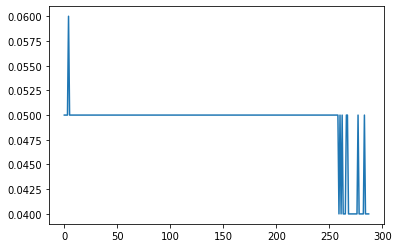

In [171]:
data["VW05"].plot()

<a id='section_4_1'></a>
### 4.2  Satellite 

<a id='section_5'></a>
## 5 - Data fusion

<a id='section_6'></a>

## 6 - Model parametrization

<a id='section_7'></a>

## 7 - $W$ maps